In [1]:
import pandas as pd
import numpy  as np
import nltk
import pandas as pd
import numpy as np
import pickle
from nltk.corpus import movie_reviews

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, GRU
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras import regularizers
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

Using TensorFlow backend.
/Users/luke/AMII/.virtualenvs/workshop/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


# Visualizing Embeddings

## Loading Pre-Trained Embeddings

In [17]:
def pretrained_wordembedding_glov(word_index=None):
    # Loading Glov embeddings
    embeddings_index = {}
    f = open('../data/glove.6B.50d.txt')
    count = 0
    for line in f:
        if count == 0:
            count = 1
            continue
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    if word_index is not None:
        embedding_matrix = np.zeros((len(word_index) + 1, EMBD_DIM))
        for word, i in word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector[0:EMBD_DIM]
        print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
        return embedding_matrix
    else:
        return embeddings_index

In [6]:
embedding_matrix = pretrained_wordembedding_glov()

In [7]:
df = pd.DataFrame(embedding_matrix)

In [8]:
df = df.transpose()

In [26]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
",",0.013441,0.236820,-0.16899,0.409510,0.63812,0.477090,-0.42852,-0.55641,-0.36400,-0.239380,...,-0.080262,0.630030,0.321110,-0.467650,0.22786,0.360340,-0.378180,-0.566570,0.044691,0.30392
.,0.151640,0.301770,-0.16763,0.176840,0.31719,0.339730,-0.43478,-0.31086,-0.44999,-0.294860,...,-0.000064,0.068987,0.087939,-0.102850,-0.13931,0.223140,-0.080803,-0.356520,0.016413,0.10216
of,0.708530,0.570880,-0.47160,0.180480,0.54449,0.726030,0.18157,-0.52393,0.10381,-0.175660,...,-0.347270,0.284830,0.075693,-0.062178,-0.38988,0.229020,-0.216170,-0.225620,-0.093918,-0.80375
to,0.680470,-0.039263,0.30186,-0.177920,0.42962,0.032246,-0.41376,0.13228,-0.29847,-0.085253,...,-0.094375,0.018324,0.210480,-0.030880,-0.19722,0.082279,-0.094340,-0.073297,-0.064699,-0.26044
and,0.268180,0.143460,-0.27877,0.016257,0.11384,0.699230,-0.51332,-0.47368,-0.33075,-0.138340,...,-0.069043,0.368850,0.251680,-0.245170,0.25381,0.136700,-0.311780,-0.632100,-0.250280,-0.38097


In [9]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_model

TSNE(angle=0.5, early_exaggeration=12.0, init='pca', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=2500, n_iter_without_progress=300, perplexity=40,
   random_state=23, verbose=0)

In [ ]:
# new_values = tsne_model.fit_transform(df.iloc[0:10000, :].values)

In [10]:
# pickle.dump(tsne_model, open('tsne_model.pkl', 'wb'))

In [20]:
# pickle.dump(new_values, open('new_values.pkl', 'wb'))

In [11]:
tsne_model = pickle.load(open('tsne_model.pkl', 'rb'))

In [21]:
new_values = pickle.load(open('new_values.pkl', 'rb'))

In [22]:
labels = df.index[0:10000]

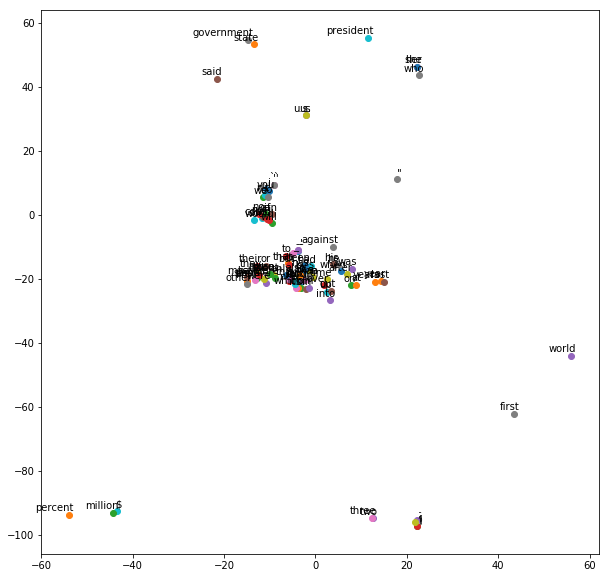

In [23]:
x = []
y = []
for value in new_values[0:100]:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(10, 10)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

# Sentiment Classification using Embeddings as Features

In [2]:
EMBD_DIM = 50
MAX_WORDS = 100000

## Load Data

In [3]:
documents = [(' '.join(list(movie_reviews.words(fileid))), category) \
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

In [4]:
documents = pd.DataFrame(documents, columns=['review', 'category'])

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(documents.review.values,\
                                                    documents.category.values, test_size=0.25)

## Encode Text using Embeddings

In [6]:
# Create Tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, lower=True)
tokenizer.fit_on_texts(X_train)

In [7]:
MAX_SEQ_LENGTH = max([len(s.split()) for s in X_train])

In [8]:
MAX_SEQ_LENGTH

2879

In [9]:
# Prepare Train Sequence (ID Sequence)
train_sequence = tokenizer.texts_to_sequences(X_train)
train_sequence = sequence.pad_sequences(train_sequence, maxlen=MAX_SEQ_LENGTH, padding='post')

In [10]:
train_sequence.shape

(1500, 2879)

In [11]:
label_encoder = LabelEncoder()

In [12]:
train_label = label_encoder.fit_transform(Y_train)

In [13]:
label_encoder.classes_

array(['neg', 'pos'], dtype=object)

## Simple DNN Model

In [14]:
NUM_UNIQUE_WORDS = len(tokenizer.word_index.keys()) + 1

In [18]:
embedding_matrix = pretrained_wordembedding_glov(tokenizer.word_index)

Null word embeddings: 2424


In [52]:
model = Sequential()
model.add(Embedding(input_dim=NUM_UNIQUE_WORDS, output_dim=EMBD_DIM, input_length=MAX_SEQ_LENGTH, \
                    weights=[embedding_matrix], trainable=False))
model.add(Conv1D(filters=64, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
# model.add(GRU(50, recurrent_regularizer=regularizers.l2(0.01), return_state=False))
model.add(Dense(30, activation='relu', kernel_regularizer=regularizers.l2(0.1))) 
# model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 2879, 50)          1764300   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2872, 64)          25664     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 718, 64)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 45952)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 30)                1378590   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 31        
Total params: 3,168,585
Trainable params: 1,404,285
Non-trainable params: 1,764,300
__________________________________________________________

In [53]:
callbacks = [EarlyStopping(monitor='val_acc', patience=5)]

In [54]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [55]:
# history = model.fit(train_sequence, train_label, verbose=2, validation_split=0.25, epochs=100, callbacks=callbacks)

Train on 1125 samples, validate on 375 samples
Epoch 1/100
 - 10s - loss: 2.0695 - acc: 0.5173 - val_loss: 1.0100 - val_acc: 0.5280
Epoch 2/100
 - 10s - loss: 0.8598 - acc: 0.6702 - val_loss: 0.8205 - val_acc: 0.6213
Epoch 3/100
 - 9s - loss: 0.7460 - acc: 0.7271 - val_loss: 1.0384 - val_acc: 0.5227
Epoch 4/100
 - 9s - loss: 0.6631 - acc: 0.8133 - val_loss: 0.7929 - val_acc: 0.6587
Epoch 5/100
 - 9s - loss: 0.5945 - acc: 0.8853 - val_loss: 0.8392 - val_acc: 0.6853
Epoch 6/100
 - 9s - loss: 0.5472 - acc: 0.9076 - val_loss: 0.8432 - val_acc: 0.6800
Epoch 7/100
 - 9s - loss: 0.4833 - acc: 0.9413 - val_loss: 0.8105 - val_acc: 0.7147
Epoch 8/100
 - 9s - loss: 0.4510 - acc: 0.9636 - val_loss: 0.9193 - val_acc: 0.6747
Epoch 9/100
 - 9s - loss: 0.4622 - acc: 0.9502 - val_loss: 0.8921 - val_acc: 0.6613
Epoch 10/100
 - 9s - loss: 0.4088 - acc: 0.9609 - val_loss: 1.2913 - val_acc: 0.5893
Epoch 11/100
 - 9s - loss: 0.5855 - acc: 0.9333 - val_loss: 0.8301 - val_acc: 0.6960
Epoch 12/100
 - 9s - loss

In [56]:
# pickle.dump(model, open('dnn_model.pkl', 'wb'))

In [57]:
model = pickle.load(open('dnn_model.pkl', 'rb'))

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


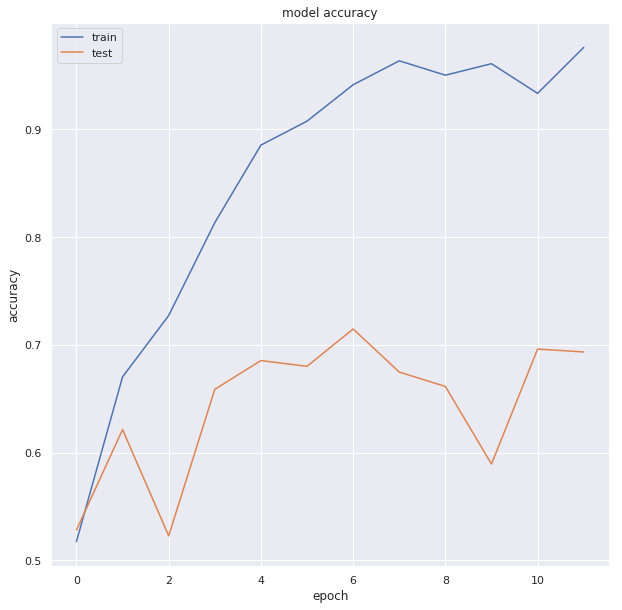

In [58]:
print(history.history.keys())
# summarize history for accuracy
plt.figure(figsize=(10,10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

## Testing

In [59]:
test_sequence = sequence.pad_sequences(tokenizer.texts_to_sequences(X_test),\
                                       maxlen=MAX_SEQ_LENGTH, padding='post')

In [60]:
test_label = label_encoder.transform(Y_test)

In [61]:
predictions = model.predict(test_sequence)

In [62]:
print("Test AUC ROC ", roc_auc_score(y_score=predictions[:, 0], y_true=Y_test=='pos'))

Test AUC ROC  0.7473593239869407


In [63]:
loss, acc = model.evaluate(test_sequence, test_label, verbose=0)

In [64]:
print("Test Accuracy: ", acc)

Test Accuracy:  0.6799999995231628


In [65]:
print('Test Loss: ', loss)

Test Loss:  0.8760680675506591


In [66]:
label_encoder.inverse_transform([1])

array(['pos'], dtype=object)

In [67]:
predicted_class = list(map(lambda x: 'pos' if x >= 0.5 else 'neg', predictions))

In [68]:
print(classification_report(y_pred=predicted_class, \
                            y_true=Y_test, target_names=['pos', 'neg']))

              precision    recall  f1-score   support

         pos       0.65      0.82      0.72       254
         neg       0.74      0.53      0.62       246

   micro avg       0.68      0.68      0.68       500
   macro avg       0.69      0.68      0.67       500
weighted avg       0.69      0.68      0.67       500

